In [1]:
import sys
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction
from bayes_opt import SequentialDomainReductionTransformer
bounds_transformer = SequentialDomainReductionTransformer()
import matplotlib as mtp
mtp.rcParams.update({'font.size':16})
import numpy as np
from random import *
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
seed(5000)
factor = 5000

In [2]:
def get_runtime(x): # or make a call to FaaS platform to get runtime or cost 
    pars = [2.67347860e+00, 2.18887259e+01, 5.49402930e-03]
    return (pars[0]+pars[1]*(1-pars[2])**(x-128))/factor


def get_lambda_cost (memory, exec_time): # calculate AWS Lambda cost, given memory allocated and execution time
    return 0.0000002+(memory/1024.0)*exec_time*0.00001667

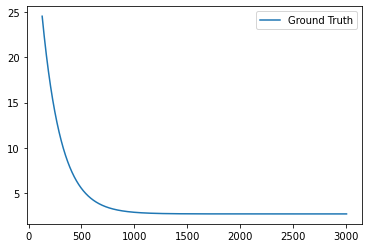

In [3]:
x = np.linspace(128, 3008, 10000-128).reshape(-1, 1)
node_type = np.linspace(0, 10000, 2).reshape(-1, 1)
y_c = get_runtime(x)*factor
plt.plot(x, y_c, label='Ground Truth');
plt.legend(loc='upper right')
plt.show()

In [4]:
# define exploration space i.e. memory values 
pbounds = { 'x': (128, 3008)}

optimizer = BayesianOptimization(
    f=None,
    pbounds=pbounds,
    verbose=2,  # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=randint(128, 3008)
)

# BO parameters 

acq_type = "ei"
xi_value = 0.001 # more exploration 
kappa_value = 10.0
alpha_value = 0.1
utility = UtilityFunction(kind=acq_type, kappa = 10, xi=xi_value)


In [5]:
def posterior(optimizer, x_obs, y_obs, grid):
    optimizer._gp.fit(x_obs, y_obs)

    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma


def plot_gp(optimizer, x, y_c, acq_type, xi_value, kappa_value):
    global graph_counter
    fig = plt.figure(figsize=(7, 7))
    steps = len(optimizer.space)
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])    
    plt.subplots_adjust(wspace=0, hspace=0.12)
    x_obs = np.array([[res["params"]["x"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])
    mu, sigma = posterior(optimizer, x_obs, y_obs, x)
    axis.plot(x, get_runtime(x)*factor, linewidth=3, label='Measured')
    axis.plot(x, mu*factor, '--', color='k', label='Prediction')
    axis.plot(x_obs.flatten(), get_runtime(x_obs)*factor, 'D', markersize=8, label=u'Observations', color='r')
    axis.fill_between(x.flatten(), (mu + sigma)*factor, (mu - sigma)*factor, alpha=0.3)

    axis.set_xlim((128, 3008))
    axis.set_ylim((0, 40))
    axis.set_ylabel('Execution Time (ms)', fontdict={'size':20})
    axis.set_xlabel('Memory (MB)', fontdict={'size':20})
    y_max = optimizer.max['target']
    axis.legend(loc=1, bbox_to_anchor=(0.77, 0.99), borderaxespad=0., ncol=2, prop={'size': 14})
    return mu,sigma

Next point to probe is: {'x': 1536}
Found the target value to be: 0.0005365683949736324
Samples so far: 1
Next point to probe is: {'x': 1280}
Found the target value to be: 0.0005423687929785722
Samples so far: 2
Next point to probe is: {'x': 512}
Found the target value to be: 0.0010625208888289798
Samples so far: 3
Next point to probe is: {'x': 3008}
Found the target value to be: 0.0005346962830508316
Samples so far: 4
Next point to probe is: {'x': 448}
Found the target value to be: 0.0012856557562609297
Samples so far: 5
Next point to probe is: {'x': 128}
Found the target value to be: 0.0049124409
Samples so far: 6
Next point to probe is: {'x': 192}
Found the target value to be: 0.0036116691635254
Samples so far: 7
Next point to probe is: {'x': 128}
Found the target value to be: 0.0049124409
Samples so far: 8
Next point to probe is: {'x': 2240}
Found the target value to be: 0.0005347344518615421
Samples so far: 9
Next point to probe is: {'x': 2560}
Found the target value to be: 0.0005

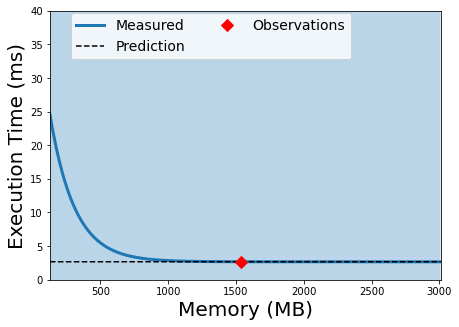

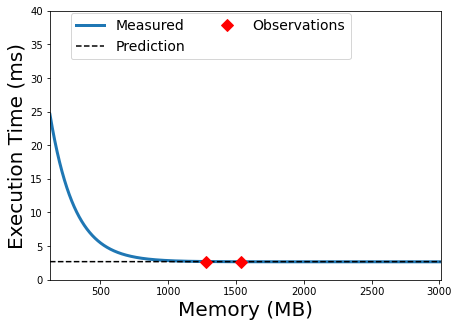

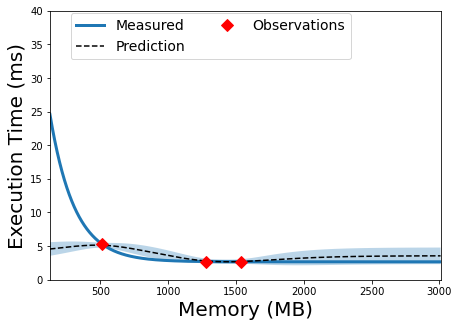

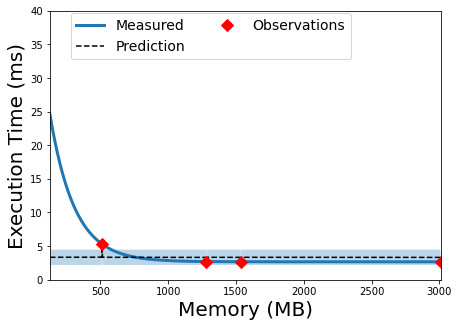

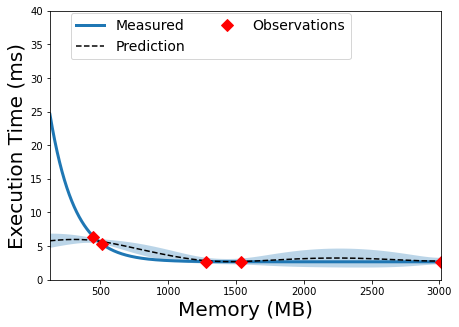

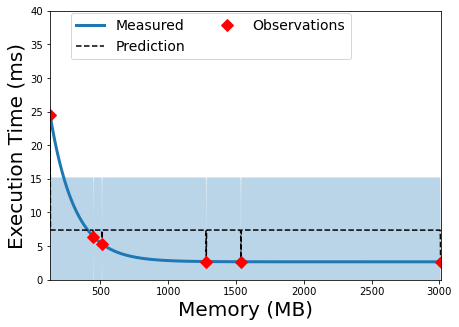

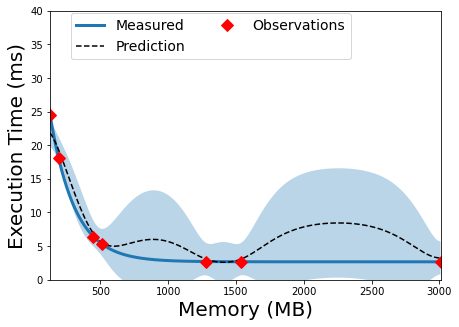

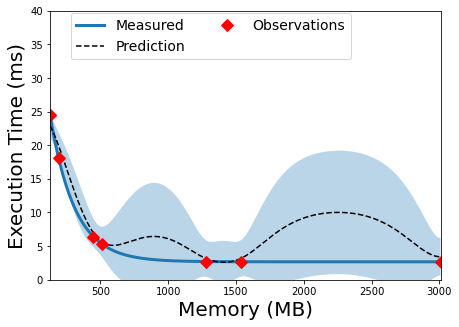

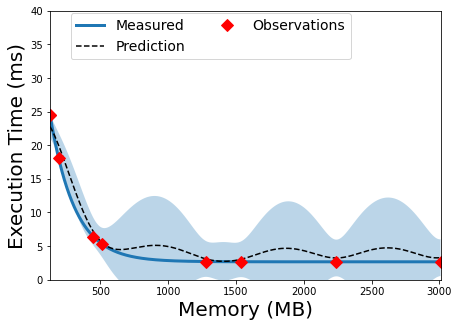

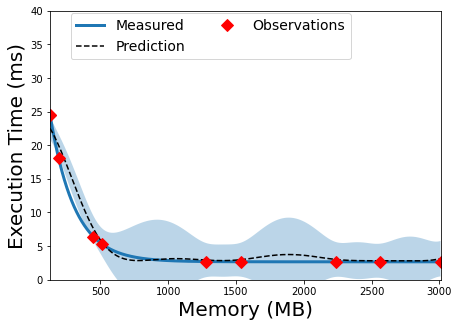

In [6]:
# BO in action ...
counter = 1
total_samples = 10 

while True:
    
    next_point = optimizer.suggest(utility)
    next_point['x']= int(round(float(next_point['x']))/ float(64)) * 64
    print("Next point to probe is:", next_point)
    target = get_runtime(**next_point)
    print("Found the target value to be:", target)
    next_point['x'] = next_point['x']+random()
    optimizer.register(params=next_point, target=target)
    optimizer.set_gp_params(alpha=alpha_value)
    optimizer.set_gp_params(normalize_y=True)

    mu, sigma = plot_gp(optimizer, x, y_c, acq_type, xi_value, kappa_value)
    print ('Samples so far:', counter)
    counter+=1
    if counter > total_samples:
        break
    
print("BEST:", optimizer.max)


In [7]:
##plot grounth truth and prediction

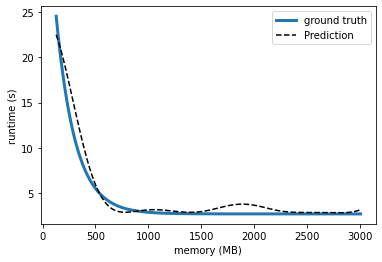

In [23]:
predicted_runtimes =  mu*factor

plt.plot(x, get_runtime(x)*factor, linewidth=3, label='ground truth')
plt.plot(x,predicted_runtimes, '--', color='k', label='Prediction')
plt.xlabel('memory (MB)')
plt.ylabel('runtime (s)')
plt.legend()
